# Семинар_8 Стекинг моделей

Цель семинара: освоить основные подходы стекинга

План семинара:

* Практика - попробуем StackingClassifier из sklearn
* Практика - стекинг с фичами
* Практика - разберемся с кросс валлидацией во время стекинга
* Практика - попробуем LightAutoML от Сбера
* Подведение итогов - проанализируем и обсудим результаты

Сразу поставим устанавливаться фреймворк LightAutoML

In [1]:
!pip install -qq -U lightautoml==0.3.8b1
!pip install -qq -U pandas==1.5.3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.8.2 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
albumentations 1.4.0 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 15.0.2 which is incompatible.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.1.5 which is incompatible.
chex 0.1.85 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
dask-expr 1.0.4 requires pandas>=2, but you have pandas 1.4.3 which is incompatible.
featuretools 1.30.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
featuretools 

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics

import numpy as np
from xgboost import XGBClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
import lightgbm as lgb
import torch

import pandas as pd
import time

pd.set_option('display.max_columns', None)

# 1. StackingClassifier из библеотеки sklearn (10 мин)

В основе стекинга - метамодель, которая будет на вход принимать предсказания базовых моделей и по ним предсказывать целевую переменную.

In [3]:
train = pd.read_csv('/kaggle/input/seminar1/train_multiclass.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv')
train.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,target
0,0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0,3
1,1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1,6
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0,2
3,3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0,2
4,4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1,6


In [4]:
targets = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

X = train.drop(columns=targets + ['target', 'id'])
y = train['target']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                  random_state=43, stratify=y)

Для начала просто запустим наши алгоритмы, которые мы в дальнейшем будем стекать

In [6]:
clf_rf = RandomForestClassifier(n_estimators=120, random_state=42)
clf_rf.fit(X_train, y_train)

y_pred_proba_rf = clf_rf.predict_proba(X_test)

roc_auc = roc_auc_score(y_test, y_pred_proba_rf, multi_class='ovo')
roc_auc

0.8421011099722924

In [7]:
clf_lg = LGBMClassifier(random_state=43,
        objective="multiclass",
        n_estimators=200,
        num_class=8,
        n_jobs=-1,
)

clf_lg.fit(X_train, y_train, verbose=False,
        eval_set=[(X_test, y_test)],
        callbacks=[lgb.early_stopping(stopping_rounds=50)],
    )

y_lg_mc = clf_lg.predict_proba(X_test)
roc_auc_score(y_test, y_lg_mc, multi_class='ovo')

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's multi_logloss: 1.06599


0.8554545880034186

In [8]:
cb_mc = CatBoostClassifier(random_seed=43,
                           eval_metric='AUC',
                           learning_rate=0.1
                           )

cb_mc.fit(X_train, y_train, eval_set=(X_test, y_test),
          verbose=100, early_stopping_rounds=100)

y_cb_mc = cb_mc.predict_proba(X_test)
roc_auc_score(y_test, y_cb_mc, multi_class='ovo')

0:	test: 0.7906086	best: 0.7906086 (0)	total: 110ms	remaining: 1m 49s
100:	test: 0.9178482	best: 0.9178482 (100)	total: 3.72s	remaining: 33.2s
200:	test: 0.9192138	best: 0.9193226 (171)	total: 7.21s	remaining: 28.7s
300:	test: 0.9190907	best: 0.9197072 (259)	total: 11.1s	remaining: 25.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9197071666
bestIteration = 259

Shrink model to first 260 iterations.


0.8619144795002696

Для StackingClassifier sklearn нам нужно определить базовые модели, которые будут формировать превичные предсказания и мета модель. Мета модель будет использовать предсказания базовых моделей в качестве входных фичей.

* Запустите [StackingClassifier (дока)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html)
* В качестве base_estimators используем RandomForest и LGBMClassifier.
* В качестве meta_estimator - логистическую регрессию.

In [9]:
base_estimators = [
    ('rf', RandomForestClassifier(n_estimators=120, random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42,
        objective="multiclass",
        n_estimators=42,
        num_class=8,
        n_jobs=-1,))
]
meta_estimator = LogisticRegression()

stacking_clf = StackingClassifier(estimators=base_estimators, final_estimator=meta_estimator)

stacking_clf.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=120,
                                                       random_state=42)),
                               ('lgbm',
                                LGBMClassifier(n_estimators=42, num_class=8,
                                               objective='multiclass',
                                               random_state=42))],
                   final_estimator=LogisticRegression())

In [10]:
y_pred = stacking_clf.predict_proba(X_test)
score = roc_auc_score(y_test, y_pred, multi_class='ovo')
score

0.8436538391768517

А теперь попробуем в качестве метамодели использовать CatBoost

In [11]:
base_estimators = [
    ('rf', RandomForestClassifier(n_estimators=120, random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42,
        objective="multiclass",
        n_estimators=41,
        num_class=8,
        n_jobs=-1,))
]
meta_estimator = CatBoostClassifier(random_seed=43, verbose=False,
                           eval_metric='AUC',
                           #iterations=100,
                           learning_rate=0.1
                           )

stacking_clf = StackingClassifier(estimators=base_estimators, final_estimator=meta_estimator)

stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=120,
                                                       random_state=42)),
                               ('lgbm',
                                LGBMClassifier(n_estimators=41, num_class=8,
                                               objective='multiclass',
                                               random_state=42))],
                   final_estimator=<catboost.core.CatBoostClassifier object at 0x794cb0b4cc10>)

In [12]:
y_pred = stacking_clf.predict_proba(X_test)
score = roc_auc_score(y_test, y_pred, multi_class='ovo')
score

0.8453512065219331

# 2. Стекинг с фичами (10 мин)

А теперь давайте самостоятельно сделаем предсказания базовыми моделями, а на вход к метамодели подадим предсказания базовых и изначальные фичи

Предскажим вероятности на трейн выборке

In [13]:
clf_lg.fit(X_train, y_train, verbose=False,
        eval_set=[(X_test, y_test)],
        callbacks=[lgb.early_stopping(stopping_rounds=50)],
    )
clf_rf.fit(X_train, y_train)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's multi_logloss: 1.06599


RandomForestClassifier(n_estimators=120, random_state=42)

In [14]:
y_pred_proba_lg = clf_lg.predict_proba(X_train)
y_pred_proba_rf = clf_rf.predict_proba(X_train)

* Примержьте полученные вероятности к изначальным фичам в X_train

In [15]:
X_tr_new = np.column_stack((y_pred_proba_lg, y_pred_proba_rf, X_train))

* Обучите мета-модель на полученном трейне

In [16]:
meta_estimator = CatBoostClassifier(random_seed=43, verbose=100,
                           eval_metric='AUC',
                           learning_rate=0.1
                           )

In [17]:
meta_estimator.fit(X_tr_new, y_train)

0:	total: 66.2ms	remaining: 1m 6s
100:	total: 4.29s	remaining: 38.2s
200:	total: 8.45s	remaining: 33.6s
300:	total: 12.6s	remaining: 29.2s
400:	total: 16.6s	remaining: 24.8s
500:	total: 20.7s	remaining: 20.6s
600:	total: 24.8s	remaining: 16.4s
700:	total: 28.8s	remaining: 12.3s
800:	total: 33.3s	remaining: 8.27s
900:	total: 37.3s	remaining: 4.1s
999:	total: 41.3s	remaining: 0us


* Сделайте предсказания на отложенной выборке и посмотрите скор

In [18]:
y_pred_proba_lg = clf_lg.predict_proba(X_test)
y_pred_proba_rf = clf_rf.predict_proba(X_test)
X_te_new = np.column_stack((y_pred_proba_lg, y_pred_proba_rf, X_test))

In [19]:
y_proba_meta = meta_estimator.predict_proba(X_te_new)
score = roc_auc_score(y_test, y_proba_meta, multi_class='ovo')
score

0.7608863705006514

Скор получился не очень.
Это произошло, потому что мы на одном и том же наборе обучили базовые модели, а потом сделали предсказания базовыми моделями. Т.е. произошел лик. Мы сначала переобучились на трейне, сделали предсказания для трейна. И далее на этих предсказаниях обучали метамодель.

А теперь попробуем разбить наш трейн (X_train) на трейн для базовых моделей и трейн для метамодели. 

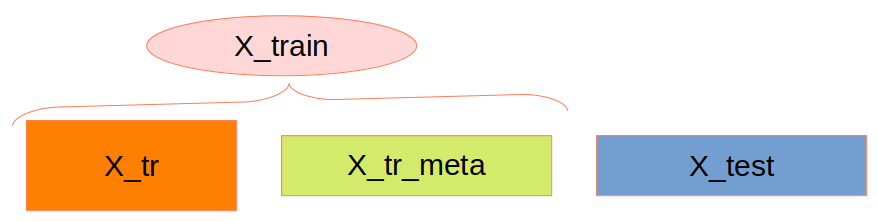

Мы хотим разбить нашу выборку X_train на X_tr и X_tr_meta.

На X_tr мы будем обучать первичные модели. 

Далее сделаем предсказания первичными моделями на X_tr_meta, смерджим с изначальными фичами X_tr_meta.
И на X_tr_meta обучим метамодель. 

Далее нам нужно будет получить предсказния для X_test первичными моделями, смерджить с X_test
и скормить полученный датафрейм метамодели.


In [20]:
X_tr, X_tr_meta, y_tr, y_tr_meta = train_test_split(X_train, y_train, test_size=0.3,
                                                  random_state=43, stratify=y_train)

In [21]:
clf_lg.fit(X_tr, y_tr, verbose= -100,
        eval_set=[(X_test, y_test)],
        callbacks=[lgb.early_stopping(stopping_rounds=50)],
    )
clf_rf.fit(X_tr, y_tr)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 1.07698


RandomForestClassifier(n_estimators=120, random_state=42)

Делаем предсказания по X_tr_meta

In [22]:
y_pred_proba_lg = clf_lg.predict_proba(X_tr_meta)
y_pred_proba_rf = clf_rf.predict_proba(X_tr_meta)

Мерджим предсказания с изначальными фичами

In [23]:
X_tr_meta = np.column_stack((y_pred_proba_lg, y_pred_proba_rf, X_tr_meta))

In [24]:
meta_estimator = CatBoostClassifier(random_seed=43, verbose=False,
                           eval_metric='AUC',
                           learning_rate=0.1
                           )
meta_estimator.fit(X_tr_meta, y_tr_meta)

Делаем предсказания по X_test и мерджим предсказания с изначальными фичами

In [25]:
y_pred_proba_lg = clf_lg.predict_proba(X_test)
y_pred_proba_rf = clf_rf.predict_proba(X_test)
X_test = np.column_stack((y_pred_proba_lg, y_pred_proba_rf, X_test))

In [26]:
y_proba_meta = meta_estimator.predict_proba(X_test)
score = roc_auc_score(y_test, y_proba_meta, multi_class='ovo')
score

0.8371302808116703

# 3. LightAutoML (Lama) (20 мин)

* Open source фреймворк от Сбера
* Можно решать и таблички и nlp и зрение
* Кастомизация
* Задаем время тренировки и алгоритмы далее система все сделает сама
* Стэкинг на стероидах

Для выполнения задания вам пригодится [дока](https://lightautoml.readthedocs.io/en/latest/)

[github](https://github.com/sb-ai-lab/LightAutoML) проекта

In [27]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

Параметры обучения
* TIMEOUT показывает сколько секунд будет происходить тренировка

Для обучения нам нужно подать датафрейм и указать колонку, которая является таргетом.
Мы могли бы сразу подать изначальный трейн датафрейм (переменная train) и потом сделать out-of-fold предсказания на тесте (переменная test) для нашего сабмита.
Но чтобы по-честному сравнить работоспособность разных подходов сохраним первоначальное разбиение на трейн и тест.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                  random_state=43, stratify=y)

Примержим к трейну таргет

In [29]:
X_train['target'] = y_train

In [30]:
N_THREADS = 4 # threads cnt for lgbm and linear models
N_FOLDS = 3 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TIMEOUT = 5 * 60 # Time in seconds for automl run
TARGET = 'target' # Target column name

In [31]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

* Установите правильную задачу
* Посмотрите возможные варианты в документации. Мы решаем мультикласс. Но можно решать и как мультилейбл.

In [32]:
task = Task('multiclass', metric='auc_mu')

* Укажем целевую колонку, а также столбцы, которые нужно выбросить

In [33]:
roles = {
    'target': TARGET,
    'drop': []### столбцы которые отбросим
}

В параметре 'use_algos' мы указываем тренируемые алгоритмы. В первой квадратной скобке указываются алгоритмы превого уровня. В следующей квадратной скобке указываем мета алгоритмы. Мы можем застекать несколько раз указав несколько квадратных скобок.  

Параметр 'skip_conn' регулирует, будет ли осуществляться передача фичей, например, с первого слоя на третий в стекинге. 

In [34]:
automl = TabularUtilizedAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       general_params = {'use_algos': [
                                                       ['lgb','xgb'], # базовые модели
                                                       ['rf']# мета модель
                       ], 
                                         'skip_conn': False}, # добавляем фичи
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS},
                       tuning_params = {'max_tuning_time': 1200}, # параметры Оптюны
                       )
oof_pred = automl.fit_predict(X_train, roles = roles, verbose = 1)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred[:10], oof_pred.shape))

[18:12:12] Start automl utilizator with listed constraints:
[18:12:12] - time: 300.00 seconds
[18:12:12] - CPU: 4 cores
[18:12:12] - memory: 16 GB

[18:12:12] If one preset completes earlier, next preset configuration will be started

[18:12:12] ==================================================
[18:12:12] Start 0 automl preset configuration:
[18:12:12] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'nn_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[18:12:13] Stdout logging level is INFO.
[18:12:13] Task: multiclass

[18:12:13] Start automl preset with listed constraints:
[18:12:13] - time: 300.00 seconds
[18:12:13] - CPU: 4 cores
[18:12:13] - memory: 16 GB

[18:12:13] Train data shape: (15358, 28)



/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:37: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


[18:12:35] Layer 1 train process start. Time left 277.72 secs
[18:12:36] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[18:16:19] Time limit exceeded after calculating fold 1

[18:16:19] Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = 0.890472641099212
[18:16:19] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[18:16:19] Time left 53.53 secs

[18:16:19] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.

[18:16:19] Layer 1 training completed.

[18:16:19] Automl preset training completed in 246.47 seconds

[18:16:19] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (2 averaged models Lvl_0_Pipe_0_Mod_0_LightGBM) 

[18:16:19] ==================================================
oof_pred:
array([[0.02515407, 0.02056164, 0.7218708 , 0.00998849, 0.00854117,
        0.07315461, 0.12118571, 0.01954354],
       [0.07085165, 0.03594754, 0.0751396 , 0.0136142 , 0.01398428,
        0.2847424 , 0.46256214, 0.04315819],
       [  

Сделаем предикт на тесте

In [35]:
y_proba = automl.predict(X_test)

Оцените метрику
* В каком формате выдает предсказания Лама?

In [36]:
score = roc_auc_score(y_test, y_proba.data,
                      multi_class='ovo')
score

0.8562600839210782

## Попробуйте поменять базовые модели и запустите обучение стеккинга с фичами, сравните скор.

In [37]:
automl = TabularUtilizedAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       general_params = {'use_algos': [
                                                       ['lgb','cb'], # базовые модели
                                                       ['rf']# мета модель
                       ], 
                                         'skip_conn': True}, # добавляем фичи
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS},
                       tuning_params = {'max_tuning_time': 1200}, # параметры Оптюны
                       )
oof_pred = automl.fit_predict(X_train, roles = roles, verbose = 1)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred[:10], oof_pred.shape))

[18:16:20] Start automl utilizator with listed constraints:
[18:16:20] - time: 300.00 seconds
[18:16:20] - CPU: 4 cores
[18:16:20] - memory: 16 GB

[18:16:20] If one preset completes earlier, next preset configuration will be started

[18:16:20] ==================================================
[18:16:20] Start 0 automl preset configuration:
[18:16:20] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'nn_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[18:16:20] Stdout logging level is INFO.
[18:16:20] Task: multiclass

[18:16:20] Start automl preset with listed constraints:
[18:16:20] - time: 300.00 seconds
[18:16:20] - CPU: 4 cores
[18:16:20] - memory: 16 GB

[18:16:20] Train data shape: (15358, 28)

[18:16:23] Layer 1 train process start. Time left 296.45 secs
[18:16:25] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[18:18:17] Time limit exceeded after calculating fold 0

[18:18:17] Fitting Lvl_0_Pipe_0_Mod_0_LightGBM 

Сделаем предикт на тесте

In [38]:
y_proba = automl.predict(X_test)

Оцените метрику
* В каком формате выдает предсказания Лама?

In [39]:
score = roc_auc_score(y_test, y_proba.data,
                      multi_class='ovo')
score

0.8629639699274498

### *Попробуйте Ламу для мультилэйбл задачи.

# 4. Сделайте сабмит для Ламы (10 мин)

* Запустите Ламу на всем трейн датасете. И далее предскажите на тесте и сделайте сабмит

In [40]:
submission = pd.DataFrame(
    automl.predict(test).data[:, :-1],
    columns=targets,
    index=test.id
).reset_index()
submission.to_csv('submission.csv', index=False)
submission.head(5)

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.452823,0.009084,0.012684,0.001934,0.030121,0.130262,0.326449
1,19220,0.285689,0.021389,0.014664,0.002006,0.159481,0.143952,0.333615
2,19221,0.007055,0.041683,0.061723,0.003752,0.006426,0.296490,0.495518
3,19222,0.119708,0.008635,0.010647,0.004155,0.007967,0.354535,0.444048
4,19223,0.006542,0.006835,0.011156,0.004314,0.007815,0.574579,0.350519


## Дополнительные эксперименты. Запустите тренировку Ламы на несколько часов


* Можно поставить несколько часов на тренировку. Посмотрите в доке, какие еще алгоритмы можно попробовать добавить.
* Перед тем, как запускать тренировку на 10 часов, убедитесь, что сможете сделать сабмит из out-of-fold предсказаний ламы.
* И конечно же, можно сделать блендинг стекинга с другими моделями))